# Import Modules

In [24]:
import os
import pandas as pd
import numpy.random as rnd
import warnings
import json
import sqlalchemy as sql
import datetime
import yfinance as yf
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from MCForecastTools import MCSimulation
from bokeh.plotting import figure, output_file
from bokeh.resources import INLINE



%matplotlib inline

#warnings.filterwarnings("ignore")
#pd.options.display.float_format = '{:.4%}'.format

# Data Input for Universe (Multiple Asset Classes)

In [25]:
# Date range
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

# Tickers of assets
assets = ["MSFT", "TSLA", "META", "UNH", "JNJ", "JPM", "V", "LLY", "AVGO", "PG", "MA", "HD", "MRK", "NVDA", "AMZN", "BRK-B",
         "GOOG", "XOM", "CVX", "PEP", "COST", "KO", "ABBV", "ADBE", "WMT", "MCD", "CSCO", "CRM"]
assets.sort()

# Downloading data
og_data = yf.download(assets, start = start, end = end)
data = og_data.loc[:,('Adj Close', slice(None))]
data.columns = assets

Y = data[assets].pct_change().dropna()

display(start)
display(end)
display(Y)

[*********************100%***********************]  28 of 28 completed


'2018-07-10'

'2023-07-09'

,ABBV,ADBE,AMZN,AVGO,BRK-B,COST,CRM,CSCO,CVX,GOOG,...,MRK,MSFT,NVDA,PEP,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-11,-0.039256,-0.002051,0.006844,-0.028416,0.000053,-0.003543,0.019656,-0.006766,-0.031899,0.000919,...,-0.006421,-0.001371,-0.022586,-0.003100,-0.008269,-0.010885,-0.003718,0.010681,-0.007797,-0.012790
2018-07-12,0.017128,0.027205,0.023715,-0.137446,0.000263,0.014553,0.020034,0.023726,0.005991,0.025635,...,0.012278,0.021671,0.014948,-0.008975,-0.003411,-0.007054,0.005735,0.012667,-0.000116,0.001211
2018-07-13,0.010668,0.014596,0.009134,-0.035813,0.005264,0.011775,-0.003712,-0.041303,-0.001770,0.004512,...,0.003671,0.011902,-0.007603,0.010401,0.005324,0.006820,0.010350,-0.003431,0.013639,0.007498
2018-07-16,-0.003932,-0.015120,0.005218,0.003902,0.005446,-0.007805,-0.004403,0.017233,-0.008546,-0.004172,...,-0.004770,-0.004932,-0.004492,0.002396,0.002774,-0.027503,-0.006648,-0.006886,-0.000684,-0.009843
2018-07-17,-0.008727,0.014253,0.011764,0.024895,-0.008281,0.000698,0.000408,-0.003764,-0.008701,0.012620,...,-0.000959,0.009913,0.022119,0.016997,0.006287,0.040600,-0.026033,0.008522,0.006276,-0.002182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.011259,0.010790,0.019234,0.005634,0.012140,0.012583,0.003944,0.010350,0.007104,0.007999,...,0.016294,0.016386,0.036255,0.007287,0.015799,0.016582,0.008815,0.013486,0.018797,0.005155
2023-07-03,0.002078,-0.007730,-0.001074,0.010387,0.002933,0.004941,0.001846,0.001546,-0.000890,-0.003389,...,-0.009186,-0.007488,0.002624,0.002052,0.005009,0.068954,-0.005742,0.002063,0.006489,0.001958
2023-07-05,0.019332,0.004225,0.001229,-0.016635,-0.001287,0.000166,0.010253,0.001555,-0.005725,0.017170,...,-0.005510,0.000473,-0.002263,0.005280,-0.001705,0.009506,-0.013937,0.006219,-0.000569,-0.005118


In [26]:
#Set the time period and trading days
rolling_window = 30
trading_days = 252

## Set up data for k-means model

In [27]:
# Calculate annual returns from daily returns
group_level = Y.index.year
annual_returns = Y.groupby(by=group_level).mean()
annual_returns

# Annual standard deviation
annual_stdev = annual_returns.std()*np.sqrt(trading_days)
annual_stdev.head()


ABBV     0.014888
ADBE     0.027685
AMZN     0.034345
AVGO     0.020959
BRK-B    0.004991
dtype: float64

In [28]:
# Calculate rolling 30 day returns from daily returns
thirty_day_rolling = Y.rolling(window = rolling_window).mean() 
thirty_day_rolling

# 30 day rolling standard deviation
thirty_day_stdev = thirty_day_rolling.std()*np.sqrt(rolling_window)
thirty_day_stdev.head()

ABBV     0.015856
ADBE     0.020975
AMZN     0.020782
AVGO     0.019311
BRK-B    0.012280
dtype: float64

In [29]:
# annual sharpe ratio
sharpe_ratio = (annual_returns /annual_stdev).mean()
sharpe_ratio.head()

ABBV     0.024666
ADBE     0.032429
AMZN     0.020432
AVGO     0.071445
BRK-B    0.120195
dtype: float64

In [30]:
# combine all of the measures of variablity into one dataframe
asset_quant_data = pd.concat([annual_stdev,thirty_day_stdev,sharpe_ratio], axis =1)
asset_quant_data.columns = ('annual_stdev','thirty_day_stdev','sharpe_ratio')
asset_quant_data

,annual_stdev,thirty_day_stdev,sharpe_ratio
ABBV,0.014888,0.015856,0.024666
ADBE,0.027685,0.020975,0.032429
AMZN,0.034345,0.020782,0.020432
AVGO,0.020959,0.019311,0.071445
BRK-B,0.004991,0.012280,0.120195
COST,0.015544,0.014008,0.053323
CRM,0.031115,0.021290,0.026432
CSCO,0.012588,0.015909,0.035156
CVX,0.021063,0.020658,0.014997
GOOG,0.026212,0.016598,0.030552


## k-means modeling to cluster assets

In [31]:
# using a standard scaler to scale the variability metrics to avoid bias in the model

scaled_data = StandardScaler()

asset_data_scaled = scaled_data.fit_transform(asset_quant_data[['annual_stdev','thirty_day_stdev','sharpe_ratio']])



In [32]:
# Create a DataFrame with the scaled data
asset_data_scaled = pd.DataFrame(
    asset_data_scaled,
    columns=asset_quant_data.columns
)

# Copy the asset names from the original data
asset_data_scaled["Asset_Name"] = asset_quant_data.index

# Set the asset_name column as index
asset_data_scaled = asset_data_scaled.set_index("Asset_Name")

# Display sample data
asset_data_scaled.head()

,annual_stdev,thirty_day_stdev,sharpe_ratio
Asset_Name,,,
ABBV,-0.362733,-0.226240,-0.780546
ADBE,0.312712,0.441692,-0.564882
AMZN,0.664171,0.416492,-0.898189
AVGO,-0.042319,0.224539,0.519017
BRK-B,-0.885042,-0.692919,1.873356


In [33]:
# Create a list with the number of k-values to try
# Use a range from 1 to 10
k = list(range(1,10))

In [34]:
# Create an empy list to store the inertia values
inertia = []

In [35]:
for i in k:
    k_model = KMeans(n_clusters = i, random_state = 1)
    k_model.fit(asset_data_scaled)
    inertia.append(k_model.inertia_)

In [36]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k":k, "inertia":inertia}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

#check dataframe
elbow_df.head()

,k,inertia
0,1,84.000000
1,2,40.924064
2,3,19.717401
3,4,12.379247
4,5,9.081652


In [37]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.hvplot.line(x = "k", y = "inertia", title = "Elbow Curve", xticks = k)

:Curve   [k]   (inertia)

In [38]:
# Initialize the K-Means model using the best value for k
model = KMeans (n_clusters = 4, random_state = 1)

In [39]:
# Fit the K-Means model using the scaled data
model.fit(asset_data_scaled)

KMeans(n_clusters=4, random_state=1)

In [40]:
# Predict the clusters to group the assets using the scaled data
k = model.predict(asset_data_scaled)

# View the resulting array of cluster values.
k

array([2, 2, 2, 1, 3, 1, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 3, 0, 1, 1, 0, 3,
       1, 0, 1, 1, 3, 2])

In [41]:
# Create a copy of the DataFrame
asset_data_scaled_predict = asset_data_scaled.copy()

In [42]:
# Add a new column to the DataFrame with the predicted clusters
asset_data_scaled_predict["clusters"] = k

# Display sample data
asset_data_scaled_predict

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters
Asset_Name,,,,
ABBV,-0.362733,-0.226240,-0.780546,2
ADBE,0.312712,0.441692,-0.564882,2
AMZN,0.664171,0.416492,-0.898189,2
AVGO,-0.042319,0.224539,0.519017,1
BRK-B,-0.885042,-0.692919,1.873356,3
COST,-0.328091,-0.467426,0.015575,1
CRM,0.493722,0.482782,-0.731495,2
CSCO,-0.484126,-0.219269,-0.489121,1
CVX,-0.036832,0.400414,-1.049167,2


## Charts and summary of k-means

In [43]:
# Create a scatter plot using hvPlot by setting 
# `x="Sharpe Ratio"` and `y="Annual Average Returns"`. 
# Color the graph points with the labels found using K-Means and 
# the assets represented by each data point.
asset_data_scaled_predict.hvplot.scatter(
    x="annual_stdev", 
    y="sharpe_ratio",
    by = "clusters",
    title = 'k-means features plot',
    hover_cols = "Asset_Name").opts(yformatter="%.0f")


:NdOverlay   [clusters]
   :Scatter   [annual_stdev]   (sharpe_ratio,Asset_Name)

## Translating the k-means model output into segmented portfolios

<Axes: title={'center': 'Cumulative Returns of Assets in Universe over the Last 5 Years'}, xlabel='asset_name', ylabel='Return over 5yrs %'>

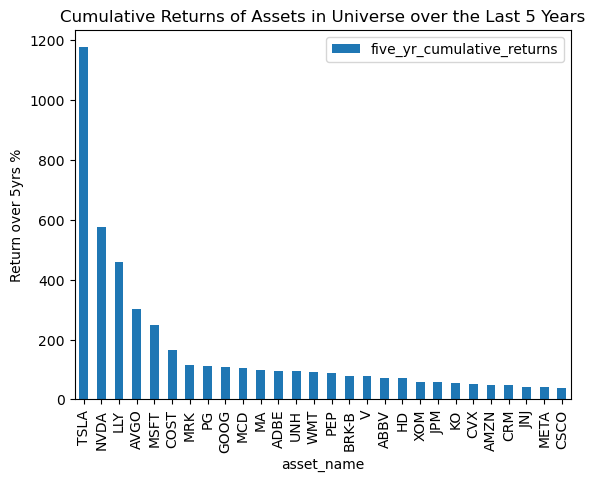

In [44]:
# calculate the cumulative returns over the entire data period 
cumulative_returns = round(((1+Y).cumprod()-1)*100, 3)

# select the last date in the period as the cumulative returns
# reset the index and transpose the row
asset_cumulative_returns = cumulative_returns.tail(1).T.reset_index()

# rename the columns to new data frame with the ticker as 'asset_name',
# and the cumulative returns as 'five_yr_cumulative_returns'
asset_cumulative_returns.columns = list(['asset_name','five_yr_cumulative_returns'])

#set asset name as new index
asset_cumulative_returns = asset_cumulative_returns.set_index('asset_name')

#sort the cumulative returns by higest to lowest
asset_cumulative_returns.sort_values(by = ['five_yr_cumulative_returns'], ascending = False,
                                    inplace = True)
asset_cumulative_returns

# plot the cumulative
asset_cumulative_returns.plot.bar(title="Cumulative Returns of Assets in Universe over the Last 5 Years",
                                 ylabel = 'Return over 5yrs %')
# save the chart to the images folder


In [45]:
cumulative_returns.hvplot.line(title = 'Cumulative Returns over 5yrs',
                              ylabel = 'Returns %',
                              )
              

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [46]:
predicted_cluster_df = pd.concat([asset_data_scaled_predict,asset_cumulative_returns], axis =1).dropna()
predicted_cluster_df

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters,five_yr_cumulative_returns
ABBV,-0.362733,-0.226240,-0.780546,2,73.120
ADBE,0.312712,0.441692,-0.564882,2,95.178
AMZN,0.664171,0.416492,-0.898189,2,48.910
AVGO,-0.042319,0.224539,0.519017,1,302.051
BRK-B,-0.885042,-0.692919,1.873356,3,79.516
COST,-0.328091,-0.467426,0.015575,1,165.211
CRM,0.493722,0.482782,-0.731495,2,47.132
CSCO,-0.484126,-0.219269,-0.489121,1,38.387
CVX,-0.036832,0.400414,-1.049167,2,50.499
GOOG,0.234954,-0.129426,-0.617030,2,108.424


In [47]:
# Plot cumulative returns vs. stdanrd deviation to identify features within the cluster

cluster0 = predicted_cluster_df.where(predicted_cluster_df['clusters']==0).dropna()
cluster0

fig0=cluster0.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                             ylabel = '% returns',
                             by = 'clusters',
                             title="Five Cumulative Returns vs. Annual Standard Deviation")


In [48]:
cluster1 = predicted_cluster_df.where(asset_data_scaled_predict['clusters']==1).dropna()
cluster1

fig1=cluster1.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                             by = 'clusters',
                             title="Cumulative Returns of Assets in Cluster 1 over the Last 5 Years")

In [49]:
cluster2 = predicted_cluster_df.where(asset_data_scaled_predict['clusters']==2).dropna()
cluster2

fig2=cluster2.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                              by = 'clusters',
                             title="Cumulative Returns of Assets in Cluster 2 over the Last 5 Years")

In [50]:
cluster3 = predicted_cluster_df.where(asset_data_scaled_predict['clusters']==3).dropna()
cluster3

fig3=cluster3.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                              by = 'clusters',
                             title="Cumulative Returns of Assets in Cluster 3 over the Last 5 Years")

In [51]:
#plot clusters together
fig =fig0 * fig1 * fig2 *fig3
fig

#fig.savefig('images/cumulative_returns_vs_stdev.png', bbox_inches ='tight')

:Overlay
   .NdOverlay.I   :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)
   .NdOverlay.II  :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)
   .NdOverlay.III :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)
   .NdOverlay.IV  :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)

In [52]:
# Grouping the clusters by the 'five_yr_cumulative_returns' and the 'annual_stdev'
# this will give us our features to characterize our porfolio
cluster_characteristics = predicted_cluster_df.groupby("clusters").mean()[['five_yr_cumulative_returns','annual_stdev','thirty_day_stdev','sharpe_ratio']]
cluster_characteristics

# box plot of the returns if we increase the universe
# this shows the distrbution of the returns
#box_plot_returns = cluster_characteristics.hvplot.box(y ='five_yr_cumulative_returns',
                                                      #by = 'clusters',
                                                     # height=400, width=400,
                                                     # title="Returns by Cluster")
#box_plot_returns


,five_yr_cumulative_returns,annual_stdev,thirty_day_stdev,sharpe_ratio
clusters,,,,
0,598.928000,2.606717,2.352002,-0.702376
1,117.370333,-0.440418,-0.475664,-0.033104
2,69.497375,0.179458,0.242803,-0.825784
3,164.640600,-0.794159,-0.658092,1.822129


In [53]:
# function 'label_clusters' takes our cluster characterisitcs and segments them
# based on how the features within the clusters vary from the median

def label_clusters(row):
    if row['annual_stdev'] > cluster_characteristics['annual_stdev'].median() and row['five_yr_cumulative_returns'] > cluster_characteristics['five_yr_cumulative_returns'].median():
        return 'HighRisk-HighReturn'
    elif row['annual_stdev'] < cluster_characteristics['annual_stdev'].median() and row['five_yr_cumulative_returns'] < cluster_characteristics['five_yr_cumulative_returns'].median():
        return 'LowRisk-LowReturn'
    else:
        return 'MediumRisk-MediumReturn'

cluster_characteristics['cluster_label'] = cluster_characteristics.apply(label_clusters, axis=1)

portfolio_segments = predicted_cluster_df.copy()
portfolio_segments['cluster_label'] = portfolio_segments['clusters'].map(cluster_characteristics['cluster_label'])
portfolio_segments.sort_values(by = ['cluster_label'], ascending = False, inplace = True)
portfolio_segments

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters,five_yr_cumulative_returns,cluster_label
ABBV,-0.362733,-0.226240,-0.780546,2,73.120,MediumRisk-MediumReturn
CVX,-0.036832,0.400414,-1.049167,2,50.499,MediumRisk-MediumReturn
WMT,-0.795798,-0.749679,1.191312,3,92.017,MediumRisk-MediumReturn
PEP,-0.838076,-1.046392,0.969521,3,87.108,MediumRisk-MediumReturn
MCD,-0.850950,-0.749301,2.116626,3,104.369,MediumRisk-MediumReturn
ADBE,0.312712,0.441692,-0.564882,2,95.178,MediumRisk-MediumReturn
HD,-0.146697,-0.139522,-0.868468,2,72.977,MediumRisk-MediumReturn
GOOG,0.234954,-0.129426,-0.617030,2,108.424,MediumRisk-MediumReturn
LLY,-0.600929,-0.052168,2.959829,3,460.193,MediumRisk-MediumReturn
XOM,0.276365,0.696231,-1.096494,2,59.739,MediumRisk-MediumReturn


## Hardcode the client data

In [54]:
#hardcode inputs from amazon lex 

investment_amount = 100000
retirement = 5

In [55]:
# test score data score Medium risk and medium return
aggregate_client_score = 3

## Selecting a portfolio based on client risk profile

In [56]:
# function that is used to pick a portfolio for the client
# aggregate client score is then used to determine the
# 'LowRisk-LowReturn','HighRisk-HighReturn','MediumRisk-MediumReturn' portfolio

def get_matching_clusters(aggregate_client_score, portfolio_segments):
    if aggregate_client_score < 7:
        target_label = 'LowRisk-LowReturn'
    elif aggregate_client_score > 14:
        target_label = 'HighRisk-HighReturn'
    else:
        target_label = 'MediumRisk-MediumReturn'
    
#Filter the dataframe for the target label
    matching_cluster = portfolio_segments[portfolio_segments['cluster_label'] == target_label]
    
    return matching_cluster
    
# portfolio selected
matching_cluster = get_matching_clusters(aggregate_client_score, portfolio_segments)
matching_cluster

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters,five_yr_cumulative_returns,cluster_label
V,-0.587015,-0.596881,0.111754,1,78.857,LowRisk-LowReturn
UNH,-0.392000,-0.481490,-0.483898,1,94.501,LowRisk-LowReturn
PG,-0.602400,-0.850541,0.411772,1,112.688,LowRisk-LowReturn
AVGO,-0.042319,0.224539,0.519017,1,302.051,LowRisk-LowReturn
MSFT,0.034693,-0.473752,0.068904,1,249.144,LowRisk-LowReturn
CSCO,-0.484126,-0.219269,-0.489121,1,38.387,LowRisk-LowReturn
MA,-0.449001,-0.289047,-0.035331,1,98.242,LowRisk-LowReturn
COST,-0.328091,-0.467426,0.015575,1,165.211,LowRisk-LowReturn
KO,-0.820877,-0.802520,0.294732,1,55.419,LowRisk-LowReturn
JPM,-0.435158,-0.071170,-0.457228,1,57.490,LowRisk-LowReturn


In [57]:
# creating a list of assets that will be used to build the porfolio
targeted_cluster_list = []
targeted_cluster_list = matching_cluster.index.tolist()
targeted_cluster_list

['V',
 'UNH',
 'PG',
 'AVGO',
 'MSFT',
 'CSCO',
 'MA',
 'COST',
 'KO',
 'JPM',
 'JNJ',
 'MRK']

## Portfolio Optimization

*Optimal Weighted Portfolio on Cluster 2*

In [58]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

cluster_stock_data = yf.download(targeted_cluster_list, start = start, end = end)
adj_close_prices = cluster_stock_data.loc[:,('Adj Close', slice(None))]
adj_close_prices.columns = targeted_cluster_list

display(start)
display(end)
display(adj_close_prices)

[*********************100%***********************]  12 of 12 completed


'2018-07-10'

'2023-07-09'

,V,UNH,PG,AVGO,MSFT,CSCO,MA,COST,KO,JPM,JNJ,MRK
Date,,,,,,,,,,,,
2018-07-10,210.607376,197.974136,36.846004,111.503426,91.650177,38.450916,196.062927,51.022160,96.584869,69.961716,237.314651,132.200928
2018-07-11,204.622665,197.272812,36.596691,110.505516,91.452484,38.297024,198.320084,50.694561,96.452454,69.383263,236.432434,133.612961
2018-07-12,176.497971,200.143753,37.464970,111.836067,91.847885,38.194393,202.153442,51.316982,98.542656,69.146591,237.788269,135.305481
2018-07-13,170.177063,202.500305,35.917549,110.234169,91.426697,38.254253,200.334061,51.505344,99.715454,69.514709,240.249344,134.841232
2018-07-16,170.841095,200.919937,36.536518,109.148735,95.054184,38.245708,198.553604,51.259655,99.223640,69.707535,238.652008,133.912796
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,867.429993,538.380005,51.350605,165.520004,144.447983,60.220001,392.732056,115.389999,340.540009,151.740005,480.640015,237.479996
2023-07-03,876.440002,541.039978,51.430000,163.350006,145.610001,60.580002,393.391083,114.330002,337.989990,152.500000,477.880005,237.970001
2023-07-05,861.859985,541.130005,51.509998,162.809998,144.639999,61.029999,394.160004,113.699997,338.149994,152.240005,471.220001,239.449997


In [59]:
mu = mean_historical_return(adj_close_prices)
S = CovarianceShrinkage(adj_close_prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('V', 0.25023),
             ('UNH', 0.20643),
             ('PG', 0.0),
             ('AVGO', 0.0),
             ('MSFT', 0.0),
             ('CSCO', 0.0),
             ('MA', 0.0),
             ('COST', 0.16403),
             ('KO', 0.23285),
             ('JPM', 0.14646),
             ('JNJ', 0.0),
             ('MRK', 0.0)])

In [60]:
ef.portfolio_performance(verbose=True)

Expected annual return: 24.3%
Annual volatility: 22.1%
Sharpe Ratio: 1.01


(0.24252138867034867, 0.22060453500552343, 1.0086890945590816)

In [61]:
latest_prices = get_latest_prices(adj_close_prices)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=investment_amount) #total_portfolio_value=100000 CHANGE THIS TO OUTPUT FROM LEX ANSWER
allocation, leftover = da.lp_portfolio()
allocation

{'UNH': 41,
 'PG': 61,
 'AVGO': 15,
 'MSFT': 17,
 'CSCO': 48,
 'MA': 6,
 'COST': 163,
 'KO': 73,
 'JPM': 107,
 'JNJ': 5,
 'MRK': 10}

In [62]:
allocation_weights = []
for key in allocation:
    allocation_weights.append(allocation[key])

total_shares = sum(allocation_weights)
total_shares

allocation_weights = [x / total_shares for x in allocation_weights]
allocation_weights  

allocated_tickers = list(allocation.keys())
allocated_tickers

['UNH', 'PG', 'AVGO', 'MSFT', 'CSCO', 'MA', 'COST', 'KO', 'JPM', 'JNJ', 'MRK']

In [63]:
dfs = []

for ticker in allocated_tickers:
    data = yf.download(ticker, start, interval='1d')
    open_df = pd.DataFrame(data['Open']).rename(columns={'Open': 'open'})
    adj_close_df = pd.DataFrame(data['Adj Close']).rename(columns={'Adj Close': 'close'})
    daily_return_df = pd.DataFrame(data['Adj Close'].pct_change()).rename(columns={'Adj Close': 'daily_return'})
    dfs.append(pd.concat([open_df, adj_close_df, daily_return_df], axis=1, keys=[ticker]*3))

allocated_data = pd.concat(dfs, axis=1).dropna()
allocated_data 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


UNH                                   PG              \
                  open       close daily_return        open       close   
Date                                                                      
2018-07-11  255.139999  236.432419    -0.003718   79.629997   69.383240   
2018-07-12  256.179993  237.788269     0.005735   79.339996   69.146576   
2018-07-13  256.390015  240.249283     0.010350   79.080002   69.514709   
2018-07-16  258.290009  238.651993    -0.006648   79.209999   69.707535   
2018-07-17  251.550003  232.439087    -0.026033   79.660004   70.145775   
...                ...         ...          ...         ...         ...   
2023-06-30  478.000000  480.640015     0.008815  149.830002  151.740005   
2023-07-03  478.100006  477.880005    -0.005742  151.479996  152.500000   
2023-07-05  476.029999  471.220001    -0.013937  151.630005  152.240005   
2023-07-06  469.350006  469.359985    -0.003947  151.199997  151.990005   
2023-07-07  465.000000  461.579987    -0.016576  151.710007  148.800003   

                               AVGO                                 MSFT  ...  \
           daily_return        open       close daily_return        open  ...   
Date                                                                      ...   
2018-07-11    -0.008269  244.949997  204.622681    -0.028416  101.150002  ...   
2018-07-12    -0.003411  207.080002  176.498001    -0.137447  102.769997  ...   
2018-07-13     0.005324  212.500000  170.177078    -0.035813  104.370003  ...   
2018-07-16     0.002774  201.600006  170.841110     0.003902  105.400002  ...   
2018-07-17     0.006287  202.210007  175.094254     0.024895  104.610001  ...   
...                 ...         ...         ...          ...         ...  ...   
2023-06-30     0.015799  868.520020  867.429993     0.005634  337.750000  ...   
2023-07-03     0.005009  868.619995  876.440002     0.010387  339.190002  ...   
2023-07-05    -0.001705  867.400024  861.859985    -0.016635  335.089996  ...   
2023-07-06    -0.001642  845.000000  848.000000    -0.016081  337.299988  ...   
2023-07-07    -0.020988  850.429993  846.750000    -0.001474  339.320007  ...   

                     KO         JPM                                  JNJ  \
           daily_return        open       close daily_return        open   
Date                                                                       
2018-07-11    -0.004003  106.309998   91.452484    -0.002157  127.410004   
2018-07-12    -0.002679  107.419998   91.847893     0.004324  127.709999   
2018-07-13     0.001567  107.300003   91.426674    -0.004586  125.320000   
2018-07-16    -0.000224  107.050003   95.054184     0.039677  126.000000   
2018-07-17     0.011625  110.690002   94.985405    -0.000724  128.529999   
...                 ...         ...         ...          ...         ...   
2023-06-30     0.003332  144.600006  144.447983     0.014014  164.860001   
2023-07-03     0.005978  146.190002  145.610001     0.008045  164.339996   
2023-07-05     0.007428  144.940002  144.639999    -0.006662  162.990005   
2023-07-06    -0.007701  143.020004  143.210007    -0.009887  162.250000   
2023-07-07    -0.013210  143.910004  144.339996     0.007890  160.470001   

                                            MRK                           
                 close daily_return        open       close daily_return  
Date                                                                      
2018-07-11  110.505524    -0.008950   59.293892   50.694572    -0.006420  
2018-07-12  111.836082     0.012041   59.580154   51.316990     0.012278  
2018-07-13  110.234169    -0.014324   59.417938   51.505356     0.003671  
2018-07-16  109.148712    -0.009847   60.047710   51.259659    -0.004770  
2018-07-17  113.017807     0.035448   59.666031   51.210522    -0.000959  
...                ...          ...         ...         ...          ...  
2023-06-30  165.520004     0.008653  113.790001  115.389999     0.016294  
2023-07-03  163.35

In [64]:
allocated_closing_prices = adj_close_prices[allocated_tickers]
allocated_closing_prices

,UNH,PG,AVGO,MSFT,CSCO,MA,COST,KO,JPM,JNJ,MRK
Date,,,,,,,,,,,
2018-07-10,197.974136,36.846004,111.503426,91.650177,38.450916,196.062927,51.022160,96.584869,69.961716,237.314651,132.200928
2018-07-11,197.272812,36.596691,110.505516,91.452484,38.297024,198.320084,50.694561,96.452454,69.383263,236.432434,133.612961
2018-07-12,200.143753,37.464970,111.836067,91.847885,38.194393,202.153442,51.316982,98.542656,69.146591,237.788269,135.305481
2018-07-13,202.500305,35.917549,110.234169,91.426697,38.254253,200.334061,51.505344,99.715454,69.514709,240.249344,134.841232
2018-07-16,200.919937,36.536518,109.148735,95.054184,38.245708,198.553604,51.259655,99.223640,69.707535,238.652008,133.912796
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,538.380005,51.350605,165.520004,144.447983,60.220001,392.732056,115.389999,340.540009,151.740005,480.640015,237.479996
2023-07-03,541.039978,51.430000,163.350006,145.610001,60.580002,393.391083,114.330002,337.989990,152.500000,477.880005,237.970001
2023-07-05,541.130005,51.509998,162.809998,144.639999,61.029999,394.160004,113.699997,338.149994,152.240005,471.220001,239.449997


In [65]:
investment_timeframe = retirement
monte_carlo_simulation = MCSimulation(
    portfolio_data= allocated_data,
    weights=allocation_weights,
    num_simulation=500,
    num_trading_days=252*investment_timeframe,
)

monte_carlo_simulation.portfolio_data.head()

UNH                                  PG             \
                  open       close daily_return       open      close   
Date                                                                    
2018-07-11  255.139999  236.432419    -0.003718  79.629997  69.383240   
2018-07-12  256.179993  237.788269     0.005735  79.339996  69.146576   
2018-07-13  256.390015  240.249283     0.010350  79.080002  69.514709   
2018-07-16  258.290009  238.651993    -0.006648  79.209999  69.707535   
2018-07-17  251.550003  232.439087    -0.026033  79.660004  70.145775   

                               AVGO                                 MSFT  ...  \
           daily_return        open       close daily_return        open  ...   
Date                                                                      ...   
2018-07-11    -0.008269  244.949997  204.622681    -0.028416  101.150002  ...   
2018-07-12    -0.003411  207.080002  176.498001    -0.137447  102.769997  ...   
2018-07-13     0.005324  212.500000  170.177078    -0.035813  104.370003  ...   
2018-07-16     0.002774  201.600006  170.841110     0.003902  105.400002  ...   
2018-07-17     0.006287  202.210007  175.094254     0.024895  104.610001  ...   

                     KO         JPM                                 JNJ  \
           daily_return        open      close daily_return        open   
Date                                                                      
2018-07-11    -0.004003  106.309998  91.452484    -0.002157  127.410004   
2018-07-12    -0.002679  107.419998  91.847893     0.004324  127.709999   
2018-07-13     0.001567  107.300003  91.426674    -0.004586  125.320000   
2018-07-16    -0.000224  107.050003  95.054184     0.039677  126.000000   
2018-07-17     0.011625  110.690002  94.985405    -0.000724  128.529999   

                                           MRK                          
                 close daily_return       open      close daily_return  
Date                                                                    
2018-07-11  110.505524    -0.008950  59.293892  50.694572    -0.006420  
2018-07-12  111.836082     0.012041  59.580154  51.316990     0.012278  
2018-07-13  110.234169    -0.014324  59.417938  51.505356     0.003671  
2018-07-16  109.148712    -0.009847  60.047710  51.259659    -0.004770  
2018-07-17  113.017807     0.035448  59.666031  51.210522    -0.000959  

[5 rows x 33 columns]

In [66]:
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995441,0.991687,1.000486,1.000634,1.003653,1.007768,1.010348,0.985618,1.012980,0.999081,...,1.006667,1.000066,0.991110,0.993866,0.995986,1.000274,0.990106,1.003793,1.012924,0.998937
2,0.997947,0.989888,1.000303,1.004491,1.007606,0.994222,1.014869,0.986900,1.004916,1.003968,...,0.997219,0.996954,0.997236,0.991174,0.990375,1.011319,0.995316,1.006799,1.021077,0.993900
3,0.989152,0.994813,0.998170,1.004312,1.002447,1.002813,1.018167,0.978502,1.001545,1.011618,...,0.995325,0.999236,0.995267,0.993747,0.994310,0.997133,0.993943,1.005849,1.020491,0.989152
4,0.992344,0.989568,0.991276,1.004997,1.010024,1.003707,1.012688,0.984440,0.994061,1.022172,...,0.991864,1.013577,0.997500,0.982574,0.992714,0.991174,1.002038,1.003321,1.033291,0.982992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.304451,2.373245,1.717482,1.771458,2.134771,3.114077,3.929697,2.213401,1.268816,2.323450,...,3.245388,3.231117,2.535142,2.996368,2.580835,1.948641,2.047683,2.336507,2.063446,2.742949
1257,3.319385,2.393553,1.735543,1.775330,2.128289,3.120281,3.910483,2.231294,1.257649,2.353755,...,3.219491,3.317050,2.510577,2.982140,2.580795,1.932565,2.044522,2.346203,2.077228,2.737758
1258,3.305268,2.401720,1.736598,1.774405,2.102095,3.119293,3.916296,2.252809,1.256118,2.377517,...,3.178517,3.349408,2.495225,3.007043,2.582056,1.932940,2.050229,2.355782,2.077019,2.706353
1259,3.313606,2.395491,1.739793,1.780660,2.086099,3.122446,3.942832,2.291618,1.252581,2.381420,...,3.186456,3.361500,2.499890,3.017035,2.593338,1.934065,2.048143,2.358851,2.076217,2.707686


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

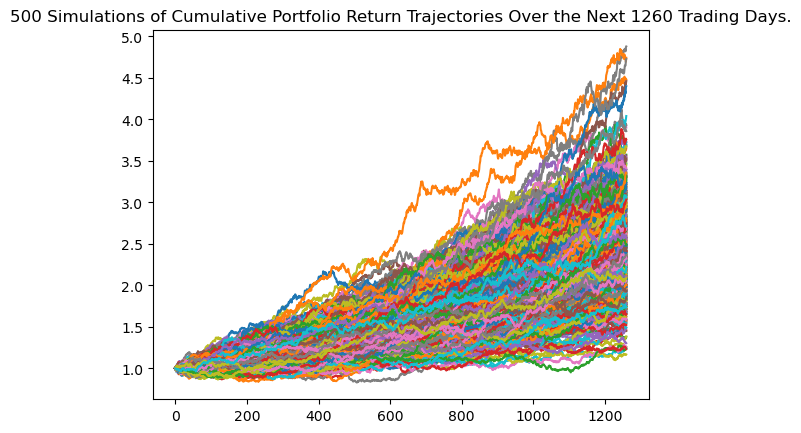

In [67]:
monte_carlo_simulation.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

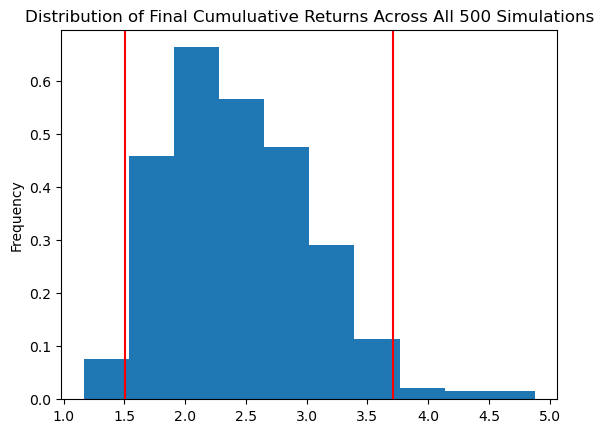

In [68]:
monte_carlo_simulation.plot_distribution()

In [69]:
monte_carlo_simulation_statistics = monte_carlo_simulation.summarize_cumulative_return()
monte_carlo_simulation_statistics

,count,mean,std,min,25%,50%,75%,max,95% CI Lower,95% CI Upper
1260,500.0,2.44034,0.604829,1.168081,1.992495,2.360752,2.821261,4.878277,NaN,NaN
1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50679,3.707085


In [70]:
ci_lower_ten_cumulative_return = monte_carlo_simulation_statistics[8]
ci_upper_ten_cumulative_return = monte_carlo_simulation_statistics[9]

KeyError: 8

In [ ]:
print(f"There is a 95% chance that the portfolio will provide returns within in the range of"
      f" {ci_lower_ten_cumulative_return: .2f} and {ci_upper_ten_cumulative_return: .2f} percent"
      f" over {investment_timeframe: .0f} years")